In [9]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('SBAnational.csv')
df.head()

/home/tteofili/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [11]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [12]:
# drop bad columns
df = df.dropna()
df = df.drop(columns=bad_columns)

In [13]:
# convert date to ordinal days
import datetime as dt
for c in date_col:
    df[c] = pd.to_datetime(df[c]).map(dt.datetime.toordinal)

In [14]:
# encode labels
le = sklearn.preprocessing.LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))
class_names = le.classes_
print(class_names)

['CHGOFF' 'P I F']


In [15]:
# process ordinal features
for col in ordinal:
    df[col] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
    df[col] = df[col].astype('int32')
    

In [16]:
# process money columns
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])

In [17]:
# process categorical features
cat_idxs = [df.columns.get_loc(c) for c in categorical if c in df]
print(cat_idxs)
categorical_names = {}
for c in categorical:
    le = preprocessing.LabelEncoder()
    df[c] = le.fit_transform(df[c])
    categorical_names[c] = le.classes_

[0, 1, 2, 3, 4, 8, 11, 12, 13]


In [18]:
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)


PDPs are defined as $\hat{f}_{x_S}(x_S)=\frac{1}{n}\sum_{i=1}^n\hat{f}(x_S,x^{(i)}_{C})$

[0.10369109 0.05456078 0.11501452 0.05045366 0.03368958 0.01969201
 0.01886796 0.021147   0.01493814 0.02170432 0.02113683 0.0109011
 0.01481731 0.00260219 0.1321467  0.07635276 0.         0.17731801
 0.04883301 0.06213304]


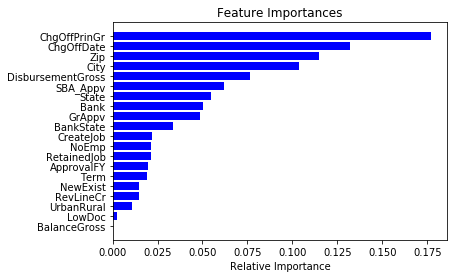

0.9702253302253302

In [19]:
rf = RandomForestClassifier(max_depth=16, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
sklearn.metrics.accuracy_score(Y_test, rf.predict(X_test))


In [23]:
data = np.array(X_train.values)

In [24]:
# Greenwell et al.: "A Simple and Effective Model-Based Variable Importance Measure"
import math
from sklearn.inspection import partial_dependence

# variable feature importance
def vfi(model, data, a, k):
    pd, _ = partial_dependence(model, data, [a])
    imp = 0
    if pd.shape[1] < 100 and pd.shape[1] < data.shape[1]: # categorical
        imp = (max(pd[0]) - min(pd[0]))/4
    else: # continuous
        for i in range(k):
            right = 0
            for j in range(k):
                right += pd[0][j]
            imp += (pd[0][i] - right/k)**2
        imp = math.sqrt(imp/(k-1))
    return imp

# standard deviation of feature importance values of feature b given a certain value of feature a
def std(model, data, b, a):
    unique = np.unique(data[:,a])
    iv_ba = []
    for uv in unique:
        uv_a = data[np.where(data[:,a] == uv)]
        iv_ba.append(vfi(model, uv_a, b, 4))
    iv_ba = np.array(iv_ba)
    return np.std(iv_ba)
    
# feature interaction based on the median of the standard deviation of conditional feature importances between two features
def fint(model, data, a, b):
    sb = std(model, data, b, a)
    sa = std(model, data, a, b)
    return (sa+sb)/2

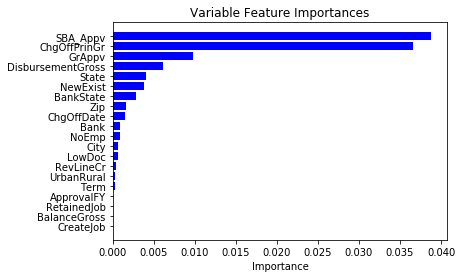

In [25]:
#feature importance bar chart
fis = []
for f in range(data.shape[1]):
    fis.append(vfi(rf, data, f, 4))
fis = np.array(fis)

indices = np.argsort(fis)
features = X_train.columns
plt.title('Variable Feature Importances')
plt.barh(range(len(indices)), fis[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.show()

In [26]:
fint(rf, data, 1, 2)

0.0020059298965339023

In [ ]:
#feature interactions heatmap
import itertools

data = np.array(X_train.values)
fints = []
for x in itertools.product(range(data.shape[1]), range(data.shape[1])):
    if x[0]!=x[1]:
        fints.append(fint(rf, data, x[0], x[1]))
    else:
        fints.append(0)
fints = np.array(fints)

rfints = fints.resphape(20,20)
plt.imshow(rfints, cmap='hot', interpolation='nearest')
plt.show()

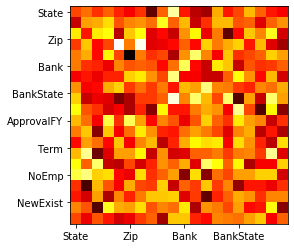

In [27]:
from sklearn.base import clone

# Sejong Oh: "Feature interaction in terms of prediction performance"
def fi_pp(model, X, Y, a, b, mode='classification'):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    
    full_model = clone(model)
    full_model.fit(X_train, Y_train)
    score = sklearn.metrics.accuracy_score(Y_test, full_model.predict(X_test))
    
    a_model = clone(model)
    a_model.fit(np.delete(X_train, [a], 1), Y_train)
    a_score = sklearn.metrics.accuracy_score(Y_test, a_model.predict(np.delete(X_test, [a], 1)))
    
    b_model = clone(model)
    b_model.fit(np.delete(X_train, [b], 1), Y_train)
    b_score = sklearn.metrics.accuracy_score(Y_test, b_model.predict(np.delete(X_test, [b], 1)))
    
    ab_model = clone(model)
    ab_model.fit(np.delete(X_train, [a, b], 1), Y_train)
    ab_score = sklearn.metrics.accuracy_score(Y_test, ab_model.predict(np.delete(X_test, [a, b], 1)))
        
    if mode == 'classification':
        # err(a)+err(b)-err(a,b)
        return (2*score-a_score-b_score)-(score-ab_score)
    elif mode == 'regression':
        #err(a,b)-(err(a)+err(b))
        return (score-ab_score)-(2*score-a_score-b_score)
    else:
        raise ValueError('unsupported mode '+str(mode))

In [28]:
inputs = np.array(X)
targets = np.array(Y)

fi_pp(RandomForestClassifier(max_depth=16, random_state=0, n_estimators=10), inputs, targets, 0, 1)

-0.00012432012432006534

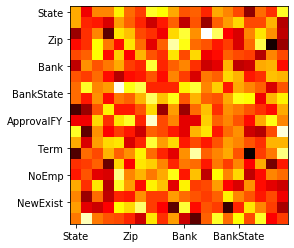

In [53]:
#feature interactions in terms of prediction performance heatmap
import itertools

fints = []
for x in itertools.product(range(data.shape[1]), range(data.shape[1])):
    fints.append(fi_pp(RandomForestClassifier(max_depth=16, random_state=0, n_estimators=10), inputs, targets, x[0], x[1]))
fints = np.array(fints)

rfints = fints.reshape(20,20)
fig, ax = plt.subplots()
plt.imshow(rfints, cmap='hot', interpolation='nearest')

features = list(X_train)
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.show()

$H^2_{j}=\sum_{i=1}^n\left[\hat{f}(x^{(i)})-PD_j(x_j^{(i)})-PD_{-j}(x_{-j}^{(i)})\right]^2/\sum_{i=1}^n\hat{f}^2(x^{(i)})$

In [ ]:
#H. Friedman et al.: "PREDICTIVE LEARNING VIA RULE ENSEMBLES"
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

def h_stat(model, j, data):
    jpd, jaxes = partial_dependence(model, data, j)
    print(np.array(jaxes).shape)
    not_j = []
    for i in range(len(data[0])):
        if not i == j[0]:
            not_j.append(i)   
    notj_pd, notj_axes = partial_dependence(model, data, not_j)
    # TBC...
    
h_stat(rf, [0], np.array(X_train.values))